# Assignments

## Week 04

*"Due date": 04.04.2022* 

### Small programming riddle

Let's read some output of the OGGM model: 

In [19]:
import xarray as xr
with xr.open_dataset('../data/oggm_fl_ela.nc') as ds:
    ds = ds.load()

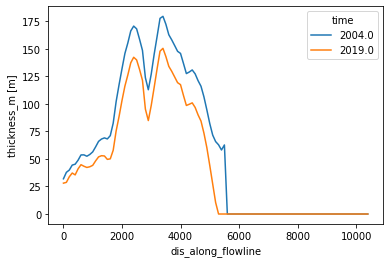

In [22]:
ds.thickness_m.sel(time=[2004, 2019]).plot(hue='time');

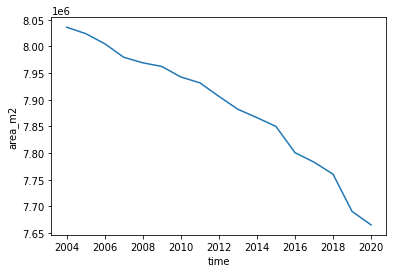

In [23]:
ds.area_m2.sum(dim='dis_along_flowline').plot();

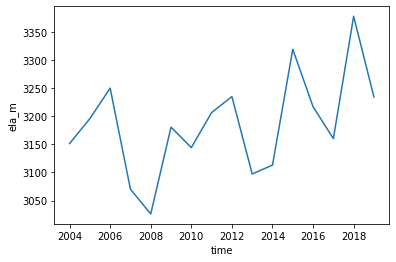

In [24]:
ds.ela_m.plot();

These data represent a glacier simulation using the [flowline](https://docs.oggm.org/en/stable/flowlines.html) representation. Each point on the flowline has a width, an area, and a thickness changing with time:

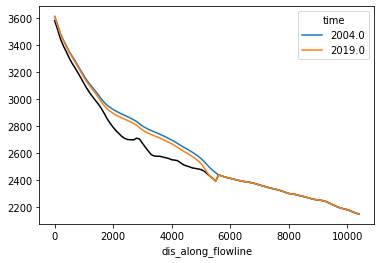

In [26]:
ds.bed_h.plot(color='k');

surface_h = ds.bed_h + ds.thickness_m
surface_h.sel(time=[2004, 2019]).plot(hue='time');